<a href="https://colab.research.google.com/github/preethir903/w266_final_project/blob/main/bert_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files 
uploaded = files.upload()


Saving full_df.csv to full_df.csv


In [ ]:
# see if full_df is present in the data
!ls

full_df.csv  sample_data


In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

     |████████████████████████████████| 4.3MB 8.0MB/s 


In [ ]:
pip install -q tf-models-official

     |████████████████████████████████| 1.6MB 4.6MB/s 
     |████████████████████████████████| 645kB 41.2MB/s 
     |████████████████████████████████| 102kB 15.0MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 38.2MB 78kB/s 
     |████████████████████████████████| 174kB 53.9MB/s 
     |████████████████████████████████| 686kB 43.9MB/s 
     |████████████████████████████████| 1.2MB 48.9MB/s 
     |████████████████████████████████| 358kB 50.3MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 


In [ ]:
pip install transformers

     |████████████████████████████████| 2.3MB 8.5MB/s 
     |████████████████████████████████| 3.3MB 49.1MB/s 
     |████████████████████████████████| 901kB 42.1MB/s 


In [ ]:
import os
import shutil
import numpy as np 
import pandas as pd 
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

from official.nlp import optimization  # to create AdamW optmizer
#Load the BERT Classifier and Tokenizer alıng with Input modules
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

from keras import backend as K


In [ ]:
# Get full dataset
df = pd.read_csv('full_df.csv', index_col = 0)
df['label'] = pd.Categorical(df['ideology'])
df['label'] = df.label.cat.codes
df.head(2)

,ideology,sentence,label
0,Liberal,"Apart from the legal rights , the fact that le...",1
1,Liberal,"Today , a sizable and growing number of indivi...",1


In [ ]:
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}



In [ ]:
# plots

def plot_loss(history): 
  history_dict = history.history
  print(history_dict.keys())

  acc = history_dict['binary_accuracy']
  val_acc = history_dict['val_binary_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)
  fig = plt.figure(figsize=(10, 6))
  fig.tight_layout()

  plt.subplot(2, 1, 1)
  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'r', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  # plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')

def plot_model_structure(classifier_model):
  # model structure
  tf.keras.utils.plot_model(classifier_model)
  #shapes of inputs
  tf.keras.utils.plot_model(classifier_model, show_shapes=True, dpi=58)

In [ ]:
seed = 1

def tf_format_data(df, batch_size, seed = seed): 
  features = df.sentence.values
  labels = df.label.values
  dataset = tf.data.Dataset.from_tensor_slices( (features, labels) )
  raw_df = dataset.shuffle(len(df), seed = seed).batch(batch_size)
  AUTOTUNE = tf.data.AUTOTUNE
  format_df = raw_df.cache().prefetch(buffer_size=AUTOTUNE) 
  return format_df

def stratified_10_fold_split(df, batch_size, fold = 0, val = True, seed = seed, tf_format = True): 
  df = df.sample(frac=1, random_state = seed) # shuffle data
  label_1 = df[df.label == df.label.unique()[0]].copy() # stratify data
  label_2 = df[df.label == df.label.unique()[1]].copy()
  # split train / test
  split = int(len(df) / (10 * 2)) 
  test1 = label_1.iloc[fold * split : fold * split + split]
  test2 = label_2.iloc[fold * split : fold * split + split]
  train1 = label_1[~label_1.index.isin(test1.index)]
  train2 = label_2[~label_2.index.isin(test2.index)]
  if val: 
    # then split train into train / val
    split = int(len(train1) / (9))
    val1 = train1.iloc[fold * split : fold * split + split]
    val2 = train2.iloc[fold * split : fold * split + split]
    train1 = train1[~train1.index.isin(val1.index)]
    train2 = train2[~train2.index.isin(val2.index)]
    # concatenate both labels 
    train, val, test = pd.concat([train1,train2]),pd.concat([val1,val2]),pd.concat([test1,test2])
    print('Train ', len(train)) 
    print('Val ', len(val)) 
    print('Test ', len(test)) 
    return tf_format_data(train, batch_size), tf_format_data(val, batch_size), tf_format_data(test, batch_size) 
  else: 
    # split only to train test, no val
    train, test = pd.concat([train1,train2]),pd.concat([test1,test2]) 
    print('Train ', len(train)) 
    print('Test ', len(test)) 
    if tf_format: 
      return tf_format_data(train, batch_size), tf_format_data(test, batch_size) 
    else: 
      return train, test   


def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  #net = tf.keras.layers.Dense(1, activation='tanh', name='classifier')(net)
  return tf.keras.Model(text_input, net)

def load_bert_to_keras(bert_model_name, do_fine_tuning):
    #load pre-trained model to keras
    tfhub_handle_encoder = map_name_to_handle[bert_model_name]
    tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]
    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
    bert_model = hub.KerasLayer(tfhub_handle_encoder)
    # build classifier model
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=do_fine_tuning, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    return outputs['pooled_output'], text_input

In [ ]:
# put all the above in one function to initialize for each bert mode

def bert_10_fold(epochs, init_lr, batch_size, create_classifier, bert_model_name = 'electra_base', do_fine_tuning = True, folds = 10): 
  print(bert_model_name)
  # get average accuracy on test (k-fold)
  accuracies = []
  for fold in range(folds): 
    print('FOLD ', fold)
    #load data - seed set upstream to 0 
    train, test = stratified_10_fold_split(df, fold = fold, val = False, batch_size = batch_size) 
    # load bert model to keras
    net, text_input = load_bert_to_keras(bert_model_name, do_fine_tuning)
    # create rest of the layers / classifier
    classifier_model = create_classifier(net, text_input)

    #loss function & evaluation
    loss = tf.keras.losses.BinaryCrossentropy()
    metrics = tf.metrics.BinaryAccuracy()

    # optimizer
    steps_per_epoch = tf.data.experimental.cardinality(train).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')
    # load BERT model
    classifier_model.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)
    
    # fit model and calculate accuracy on test    
    history = classifier_model.fit(x=train, validation_data=test, epochs=epochs)
    loss, accuracy = classifier_model.evaluate(test)
    accuracies.append(accuracy)

  return {bert_model_name: accuracies}, history, classifier_model

In [ ]:
# bert baseline, no fine tuning
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'
epochs = 5
init_lr = 3e-5
batch_size = 32
do_fine_tuning = False
folds = 2

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

In [ ]:
# electra baseline, no fine tuning
bert_model_name = 'electra_base'
epochs = 5
init_lr = 3e-5
batch_size = 32
do_fine_tuning = False
folds = 2

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

electra_base
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/5
96/96 [==============================] - 28s 220ms/step - loss: 0.6994 - binary_accuracy: 0.5199 - val_loss: 0.7052 - val_binary_accuracy: 0.5000
Epoch 2/5
96/96 [==============================] - 20s 213ms/step - loss: 0.6944 - binary_accuracy: 0.5144 - val_loss: 0.7037 - val_binary_accuracy: 0.4588
Epoch 3/5
96/96 [==============================] - 20s 214ms/step - loss: 0.6925 - binary_accuracy: 0.5259 - val_loss: 0.7033 - val_binary_accuracy: 0.4618
Epoch 4/5
96/96 [==============================] - 20s 213ms/step - loss: 0.6916 - binary_accuracy: 0.5197 - val_loss: 0.7031 - val_binary_accuracy: 0.4676
Epoch 5/5
11/11 [==============================] - 2s 185ms/step - loss: 0.7031 - binary_accuracy: 0.4706
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/5
96/96 [==============================] - 28s 220ms/step - loss: 0.7327 - binary_accuracy: 0.5054 - val_loss: 0.7041 - val_binary_accuracy: 0.5147
Epoch 2/5
96/96 [==============================] - 20s 213ms/step - loss: 0.7067 - binary_accuracy: 0.4968 - val_loss: 0.6937 - val_binary_accuracy: 0.5176
Epoch 3/5
96/96 [==============================] - 20s 213ms/step - loss: 0.7040 - binary_accuracy: 0.5046 - val_loss: 0.6914 - val_binary_accuracy: 0.5118
Epoch 4/5
96/96 [==============================] - 20s 213ms/step - loss: 0.6988 - binary_accuracy: 0.5035 - val_loss: 0.6906 - val_binary_accuracy: 0.4971
Epoch 5/5
11/11 [==============================] - 2s 185ms/step - loss: 0.6905 - binary_accuracy: 0.5029


In [ ]:
# bert baseline, fine tuning
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'
epochs = 3
init_lr = 3e-5
batch_size = 32
do_fine_tuning = True
folds = 2

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results[bert_model_name]))

bert_en_uncased_L-12_H-768_A-12
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
96/96 [==============================] - 68s 550ms/step - loss: 0.7003 - binary_accuracy: 0.5407 - val_loss: 0.6735 - val_binary_accuracy: 0.5618
Epoch 2/3
96/96 [==============================] - 52s 542ms/step - loss: 0.6348 - binary_accuracy: 0.6501 - val_loss: 0.7007 - val_binary_accuracy: 0.5941
Epoch 3/3
11/11 [==============================] - 2s 186ms/step - loss: 0.7166 - binary_accuracy: 0.6176
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
96/96 [==============================] - 66s 549ms/step - loss: 0.6954 - binary_accuracy: 0.5302 - val_loss: 0.6471 - val_binary_accuracy: 0.6471
Epoch 2/3
96/96 [==============================] - 52s 542ms/step - loss: 0.6176 - binary_accuracy: 0.6559 - val_loss: 0.6424 - val_binary_accuracy: 0.6618
Epoch 3/3
11/11 [==============================] - 2s 185ms/step - loss: 0.7318 - binary_accuracy: 0.6441


In [ ]:
# bert baseline, fine tuning
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'
epochs = 4
init_lr = 3e-5
batch_size = 32
do_fine_tuning = True
folds = 2

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results[bert_model_name]))

bert_en_uncased_L-12_H-768_A-12
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
96/96 [==============================] - 67s 550ms/step - loss: 0.7049 - binary_accuracy: 0.5200 - val_loss: 0.6754 - val_binary_accuracy: 0.5647
Epoch 2/4
96/96 [==============================] - 52s 543ms/step - loss: 0.6378 - binary_accuracy: 0.6360 - val_loss: 0.6734 - val_binary_accuracy: 0.6000
Epoch 3/4
96/96 [==============================] - 52s 543ms/step - loss: 0.5116 - binary_accuracy: 0.7569 - val_loss: 0.7508 - val_binary_accuracy: 0.6265
Epoch 4/4
11/11 [==============================] - 2s 185ms/step - loss: 0.8006 - binary_accuracy: 0.6265
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
96/96 [==============================] - 66s 550ms/step - loss: 0.7321 - binary_accuracy: 0.5033 - val_loss: 0.6526 - val_binary_accuracy: 0.6235
Epoch 2/4
96/96 [==============================] - 52s 543ms/step - loss: 0.6526 - binary_accuracy: 0.6149 - val_loss: 0.6410 - val_binary_accuracy: 0.6412
Epoch 3/4
96/96 [==============================] - 52s 542ms/step - loss: 0.5203 - binary_accuracy: 0.7486 - val_loss: 0.6989 - val_binary_accuracy: 0.6294
Epoch 4/4
11/11 [==============================] - 2s 188ms/step - loss: 0.7241 - binary_accuracy: 0.6647
Average error  0.645588219165802


In [ ]:
# bert baseline, fine tuning
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'
epochs = 4
init_lr = 2e-5
batch_size = 32
do_fine_tuning = True
folds = 2

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results[bert_model_name]))

bert_en_uncased_L-12_H-768_A-12
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
96/96 [==============================] - 67s 550ms/step - loss: 0.7524 - binary_accuracy: 0.5235 - val_loss: 0.6862 - val_binary_accuracy: 0.5441
Epoch 2/4
96/96 [==============================] - 52s 542ms/step - loss: 0.6646 - binary_accuracy: 0.5902 - val_loss: 0.6792 - val_binary_accuracy: 0.5882
Epoch 3/4
96/96 [==============================] - 52s 543ms/step - loss: 0.5710 - binary_accuracy: 0.7005 - val_loss: 0.7201 - val_binary_accuracy: 0.6000
Epoch 4/4
11/11 [==============================] - 2s 186ms/step - loss: 0.7234 - binary_accuracy: 0.6235
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
96/96 [==============================] - 67s 550ms/step - loss: 0.6996 - binary_accuracy: 0.5405 - val_loss: 0.6428 - val_binary_accuracy: 0.6412
Epoch 2/4
96/96 [==============================] - 52s 543ms/step - loss: 0.6493 - binary_accuracy: 0.6139 - val_loss: 0.6360 - val_binary_accuracy: 0.6529
Epoch 3/4
96/96 [==============================] - 52s 542ms/step - loss: 0.5546 - binary_accuracy: 0.7123 - val_loss: 0.6444 - val_binary_accuracy: 0.6706
Epoch 4/4
11/11 [==============================] - 2s 186ms/step - loss: 0.6637 - binary_accuracy: 0.6735
Average error  0.6485294103622437


In [ ]:
# bert baseline, fine tuning
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'
epochs = 4
init_lr = 3e-5
batch_size = 16
do_fine_tuning = True
folds = 2

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results[bert_model_name]))

bert_en_uncased_L-12_H-768_A-12
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
192/192 [==============================] - 71s 290ms/step - loss: 0.7091 - binary_accuracy: 0.4935 - val_loss: 0.6783 - val_binary_accuracy: 0.5765
Epoch 2/4
192/192 [==============================] - 55s 286ms/step - loss: 0.6449 - binary_accuracy: 0.6073 - val_loss: 0.6948 - val_binary_accuracy: 0.6118
Epoch 3/4
192/192 [==============================] - 55s 286ms/step - loss: 0.4853 - binary_accuracy: 0.7565 - val_loss: 0.8270 - val_binary_accuracy: 0.6206
Epoch 4/4
22/22 [==============================] - 2s 91ms/step - loss: 0.9968 - binary_accuracy: 0.6353
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
192/192 [==============================] - 71s 290ms/step - loss: 0.7075 - binary_accuracy: 0.5156 - val_loss: 0.6409 - val_binary_accuracy: 0.6147
Epoch 2/4
192/192 [==============================] - 55s 286ms/step - loss: 0.6324 - binary_accuracy: 0.6360 - val_loss: 0.6272 - val_binary_accuracy: 0.6588
Epoch 3/4
192/192 [==============================] - 55s 285ms/step - loss: 0.4621 - binary_accuracy: 0.7896 - val_loss: 0.8130 - val_binary_accuracy: 0.6500
Epoch 4/4
22/22 [==============================] - 2s 91ms/step - loss: 1.0149 - binary_accuracy: 0.6471
Average error  0.6411764919757843


In [ ]:
# bert baseline, fine tuning
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'
epochs = 4
init_lr = 3e-5
batch_size = 32
do_fine_tuning = True
folds = 2

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results[bert_model_name]))

bert_en_uncased_L-12_H-768_A-12
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
96/96 [==============================] - 67s 550ms/step - loss: 0.7391 - binary_accuracy: 0.4766 - val_loss: 0.6722 - val_binary_accuracy: 0.5971
Epoch 2/4
96/96 [==============================] - 52s 543ms/step - loss: 0.6542 - binary_accuracy: 0.6065 - val_loss: 0.6904 - val_binary_accuracy: 0.6235
Epoch 3/4
96/96 [==============================] - 52s 542ms/step - loss: 0.5462 - binary_accuracy: 0.7334 - val_loss: 0.7331 - val_binary_accuracy: 0.6118
Epoch 4/4
11/11 [==============================] - 2s 187ms/step - loss: 0.8005 - binary_accuracy: 0.6147
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
96/96 [==============================] - 66s 549ms/step - loss: 0.7558 - binary_accuracy: 0.5229 - val_loss: 0.6481 - val_binary_accuracy: 0.6265
Epoch 2/4
96/96 [==============================] - 52s 542ms/step - loss: 0.6532 - binary_accuracy: 0.6190 - val_loss: 0.6659 - val_binary_accuracy: 0.6441
Epoch 3/4
96/96 [==============================] - 52s 542ms/step - loss: 0.5294 - binary_accuracy: 0.7355 - val_loss: 0.6943 - val_binary_accuracy: 0.6441
Epoch 4/4
11/11 [==============================] - 2s 187ms/step - loss: 0.7046 - binary_accuracy: 0.6412
Average error  0.6279411613941193


In [ ]:
# electra with fine-tuning
bert_model_name = 'electra_base'
epochs = 4
init_lr = 2e-5
batch_size = 32
do_fine_tuning = True
folds = 2

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results[bert_model_name]))

electra_base
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
96/96 [==============================] - 67s 551ms/step - loss: 0.7223 - binary_accuracy: 0.4873 - val_loss: 0.6723 - val_binary_accuracy: 0.5824
Epoch 2/4
96/96 [==============================] - 52s 543ms/step - loss: 0.6496 - binary_accuracy: 0.6185 - val_loss: 0.6700 - val_binary_accuracy: 0.6324
Epoch 3/4
96/96 [==============================] - 52s 543ms/step - loss: 0.5351 - binary_accuracy: 0.7265 - val_loss: 0.7188 - val_binary_accuracy: 0.6176
Epoch 4/4
11/11 [==============================] - 2s 186ms/step - loss: 0.7171 - binary_accuracy: 0.6206
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
96/96 [==============================] - 67s 550ms/step - loss: 0.7191 - binary_accuracy: 0.5058 - val_loss: 0.6555 - val_binary_accuracy: 0.5971
Epoch 2/4
96/96 [==============================] - 52s 543ms/step - loss: 0.6509 - binary_accuracy: 0.6149 - val_loss: 0.6251 - val_binary_accuracy: 0.6441
Epoch 3/4
96/96 [==============================] - 52s 543ms/step - loss: 0.5908 - binary_accuracy: 0.6907 - val_loss: 0.6134 - val_binary_accuracy: 0.6824
Epoch 4/4
11/11 [==============================] - 2s 187ms/step - loss: 0.6254 - binary_accuracy: 0.6647
Average error  0.6426470577716827


In [ ]:
# electra with fine-tuning
bert_model_name = 'electra_base'
epochs = 4
init_lr = 2e-5
batch_size = 16
do_fine_tuning = True
folds = 2

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results[bert_model_name]))

electra_base
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
192/192 [==============================] - 74s 290ms/step - loss: 0.7102 - binary_accuracy: 0.5062 - val_loss: 0.6992 - val_binary_accuracy: 0.5412
Epoch 2/4
192/192 [==============================] - 55s 286ms/step - loss: 0.6522 - binary_accuracy: 0.6113 - val_loss: 0.7016 - val_binary_accuracy: 0.6147
Epoch 3/4
192/192 [==============================] - 55s 286ms/step - loss: 0.4921 - binary_accuracy: 0.7597 - val_loss: 0.8453 - val_binary_accuracy: 0.6147
Epoch 4/4
22/22 [==============================] - 2s 92ms/step - loss: 0.8401 - binary_accuracy: 0.6176
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
192/192 [==============================] - 69s 289ms/step - loss: 0.7031 - binary_accuracy: 0.5168 - val_loss: 0.6521 - val_binary_accuracy: 0.5912
Epoch 2/4
192/192 [==============================] - 55s 286ms/step - loss: 0.6426 - binary_accuracy: 0.6234 - val_loss: 0.6118 - val_binary_accuracy: 0.6824
Epoch 3/4
192/192 [==============================] - 55s 286ms/step - loss: 0.5018 - binary_accuracy: 0.7563 - val_loss: 0.6562 - val_binary_accuracy: 0.6882
Epoch 4/4
22/22 [==============================] - 2s 92ms/step - loss: 0.7002 - binary_accuracy: 0.6971
Average error  0.6573529243469238


In [ ]:
# electra with fine-tuning
bert_model_name = 'electra_base'
epochs = 4
init_lr = 2e-5
batch_size = 8
do_fine_tuning = True
folds = 2

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results[bert_model_name]))

electra_base
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 78s 165ms/step - loss: 0.7057 - binary_accuracy: 0.5254 - val_loss: 0.6516 - val_binary_accuracy: 0.6206
Epoch 2/4
383/383 [==============================] - 62s 163ms/step - loss: 0.6148 - binary_accuracy: 0.6757 - val_loss: 0.6861 - val_binary_accuracy: 0.6500
Epoch 3/4
383/383 [==============================] - 63s 163ms/step - loss: 0.4198 - binary_accuracy: 0.8272 - val_loss: 0.8328 - val_binary_accuracy: 0.6853
Epoch 4/4
43/43 [==============================] - 2s 49ms/step - loss: 1.0019 - binary_accuracy: 0.6618
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 79s 165ms/step - loss: 0.7088 - binary_accuracy: 0.5200 - val_loss: 0.6436 - val_binary_accuracy: 0.6235
Epoch 2/4
383/383 [==============================] - 62s 163ms/step - loss: 0.6164 - binary_accuracy: 0.6678 - val_loss: 0.6605 - val_binary_accuracy: 0.6618
Epoch 3/4
383/383 [==============================] - 62s 163ms/step - loss: 0.4145 - binary_accuracy: 0.8280 - val_loss: 0.7751 - val_binary_accuracy: 0.7088
Epoch 4/4
43/43 [==============================] - 2s 49ms/step - loss: 0.9428 - binary_accuracy: 0.7000
Average error  0.6808823347091675


In [ ]:
# electra with fine-tuning
bert_model_name = 'electra_base'
epochs = 4
init_lr = 2e-5
batch_size = 8
do_fine_tuning = True
folds = 10

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results[bert_model_name]))

electra_base
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 78s 165ms/step - loss: 0.7086 - binary_accuracy: 0.5139 - val_loss: 0.6642 - val_binary_accuracy: 0.5912
Epoch 2/4
383/383 [==============================] - 62s 162ms/step - loss: 0.6008 - binary_accuracy: 0.6650 - val_loss: 0.7506 - val_binary_accuracy: 0.6353
Epoch 3/4
383/383 [==============================] - 62s 163ms/step - loss: 0.4043 - binary_accuracy: 0.8273 - val_loss: 1.0335 - val_binary_accuracy: 0.6471
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.1740 - binary_accuracy: 0.6500
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 77s 164ms/step - loss: 0.7081 - binary_accuracy: 0.5246 - val_loss: 0.6329 - val_binary_accuracy: 0.6676
Epoch 2/4
383/383 [==============================] - 62s 163ms/step - loss: 0.6200 - binary_accuracy: 0.6552 - val_loss: 0.7080 - val_binary_accuracy: 0.6912
Epoch 3/4
383/383 [==============================] - 62s 163ms/step - loss: 0.4278 - binary_accuracy: 0.8119 - val_loss: 0.8339 - val_binary_accuracy: 0.7059
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 0.9735 - binary_accuracy: 0.6853
FOLD  2
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 78s 164ms/step - loss: 0.6990 - binary_accuracy: 0.5238 - val_loss: 0.6273 - val_binary_accuracy: 0.6706
Epoch 2/4
383/383 [==============================] - 62s 163ms/step - loss: 0.6121 - binary_accuracy: 0.6542 - val_loss: 0.6669 - val_binary_accuracy: 0.6559
Epoch 3/4
383/383 [==============================] - 62s 162ms/step - loss: 0.3999 - binary_accuracy: 0.8173 - val_loss: 0.8035 - val_binary_accuracy: 0.6500
Epoch 4/4
43/43 [==============================] - 2s 49ms/step - loss: 1.0802 - binary_accuracy: 0.6647
FOLD  3
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 77s 164ms/step - loss: 0.7040 - binary_accuracy: 0.5009 - val_loss: 0.6691 - val_binary_accuracy: 0.5941
Epoch 2/4
383/383 [==============================] - 62s 163ms/step - loss: 0.6111 - binary_accuracy: 0.6604 - val_loss: 0.7006 - val_binary_accuracy: 0.6618
Epoch 3/4
383/383 [==============================] - 62s 162ms/step - loss: 0.4446 - binary_accuracy: 0.7897 - val_loss: 0.9054 - val_binary_accuracy: 0.6676
Epoch 4/4
43/43 [==============================] - 2s 49ms/step - loss: 1.0062 - binary_accuracy: 0.6824
FOLD  4
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 78s 165ms/step - loss: 0.7105 - binary_accuracy: 0.5082 - val_loss: 0.6554 - val_binary_accuracy: 0.6265
Epoch 2/4
383/383 [==============================] - 62s 163ms/step - loss: 0.6064 - binary_accuracy: 0.6790 - val_loss: 0.7699 - val_binary_accuracy: 0.6353
Epoch 3/4
383/383 [==============================] - 62s 162ms/step - loss: 0.4233 - binary_accuracy: 0.8168 - val_loss: 1.0356 - val_binary_accuracy: 0.6500
Epoch 4/4
43/43 [==============================] - 2s 49ms/step - loss: 1.2678 - binary_accuracy: 0.6588
FOLD  5
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 80s 165ms/step - loss: 0.6954 - binary_accuracy: 0.5374 - val_loss: 0.6764 - val_binary_accuracy: 0.6294
Epoch 2/4
383/383 [==============================] - 62s 163ms/step - loss: 0.6025 - binary_accuracy: 0.6647 - val_loss: 0.7331 - val_binary_accuracy: 0.6324
Epoch 3/4
383/383 [==============================] - 62s 162ms/step - loss: 0.4691 - binary_accuracy: 0.7767 - val_loss: 0.9020 - val_binary_accuracy: 0.6412
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.0677 - binary_accuracy: 0.6294
FOLD  6
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 77s 165ms/step - loss: 0.6923 - binary_accuracy: 0.5578 - val_loss: 0.6370 - val_binary_accuracy: 0.6353
Epoch 2/4
383/383 [==============================] - 62s 162ms/step - loss: 0.6136 - binary_accuracy: 0.6596 - val_loss: 0.6941 - val_binary_accuracy: 0.6471
Epoch 3/4
383/383 [==============================] - 62s 163ms/step - loss: 0.4159 - binary_accuracy: 0.8194 - val_loss: 0.7226 - val_binary_accuracy: 0.6706
Epoch 4/4
43/43 [==============================] - 2s 52ms/step - loss: 0.9984 - binary_accuracy: 0.6676
FOLD  7
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 80s 166ms/step - loss: 0.7120 - binary_accuracy: 0.5134 - val_loss: 0.6343 - val_binary_accuracy: 0.6294
Epoch 2/4
383/383 [==============================] - 63s 165ms/step - loss: 0.5991 - binary_accuracy: 0.6719 - val_loss: 0.6159 - val_binary_accuracy: 0.6853
Epoch 3/4
383/383 [==============================] - 63s 165ms/step - loss: 0.4143 - binary_accuracy: 0.8146 - val_loss: 0.8668 - val_binary_accuracy: 0.6559
Epoch 4/4
43/43 [==============================] - 2s 52ms/step - loss: 1.2097 - binary_accuracy: 0.6471
FOLD  8
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 83s 167ms/step - loss: 0.7146 - binary_accuracy: 0.4982 - val_loss: 0.6439 - val_binary_accuracy: 0.6324
Epoch 2/4
383/383 [==============================] - 63s 165ms/step - loss: 0.6060 - binary_accuracy: 0.6685 - val_loss: 0.7973 - val_binary_accuracy: 0.6118
Epoch 3/4
383/383 [==============================] - 63s 165ms/step - loss: 0.4187 - binary_accuracy: 0.8123 - val_loss: 1.0211 - val_binary_accuracy: 0.6441
Epoch 4/4
43/43 [==============================] - 2s 52ms/step - loss: 1.1132 - binary_accuracy: 0.6765
FOLD  9
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 80s 167ms/step - loss: 0.7125 - binary_accuracy: 0.5173 - val_loss: 0.6424 - val_binary_accuracy: 0.6294
Epoch 2/4
383/383 [==============================] - 63s 164ms/step - loss: 0.6040 - binary_accuracy: 0.6729 - val_loss: 0.7064 - val_binary_accuracy: 0.6471
Epoch 3/4
383/383 [==============================] - 63s 165ms/step - loss: 0.3997 - binary_accuracy: 0.8156 - val_loss: 0.9631 - val_binary_accuracy: 0.6324
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.1594 - binary_accuracy: 0.6529
Average error  0.6614705860614777


In [ ]:
# electra with fine-tuning
bert_model_name = 'electra_base'
epochs = 4
init_lr = 2e-5
batch_size = 8
do_fine_tuning = True
folds = 2

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results[bert_model_name]))

In [ ]:
# electra with fine-tuning, regularization
bert_model_name = 'electra_base'
epochs = 4
init_lr = 2e-5
batch_size = 8
do_fine_tuning = True
folds = 2

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier', 
                              kernel_regularizer=tf.keras.regularizers.l2(0.01)
                              )(net)
  return tf.keras.Model(text_input, net)
#tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results[bert_model_name]))

electra_base
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 80s 165ms/step - loss: 0.7439 - binary_accuracy: 0.4972 - val_loss: 0.6977 - val_binary_accuracy: 0.6029
Epoch 2/4
383/383 [==============================] - 63s 164ms/step - loss: 0.6288 - binary_accuracy: 0.6692 - val_loss: 0.6961 - val_binary_accuracy: 0.6647
Epoch 3/4
383/383 [==============================] - 63s 164ms/step - loss: 0.4410 - binary_accuracy: 0.8128 - val_loss: 0.9576 - val_binary_accuracy: 0.6294
Epoch 4/4
43/43 [==============================] - 2s 51ms/step - loss: 1.3305 - binary_accuracy: 0.6118
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 77s 165ms/step - loss: 0.7325 - binary_accuracy: 0.4937 - val_loss: 0.6556 - val_binary_accuracy: 0.6500
Epoch 2/4
383/383 [==============================] - 63s 164ms/step - loss: 0.6493 - binary_accuracy: 0.6494 - val_loss: 0.6374 - val_binary_accuracy: 0.6824
Epoch 3/4
383/383 [==============================] - 63s 163ms/step - loss: 0.4596 - binary_accuracy: 0.7944 - val_loss: 0.8092 - val_binary_accuracy: 0.6912
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 0.8995 - binary_accuracy: 0.7000
Average error  0.6558823585510254


In [ ]:
# electra with fine-tuning
bert_model_name = 'electra_base'
epochs = 4
init_lr = 2e-5
batch_size = 8
do_fine_tuning = True
folds = 2

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier', 
                              kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
                              )(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results[bert_model_name]))

electra_base
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 80s 165ms/step - loss: 1.0369 - binary_accuracy: 0.5390 - val_loss: 0.9898 - val_binary_accuracy: 0.6118
Epoch 2/4
383/383 [==============================] - 63s 163ms/step - loss: 0.9364 - binary_accuracy: 0.6748 - val_loss: 1.0130 - val_binary_accuracy: 0.6588
Epoch 3/4
383/383 [==============================] - 63s 163ms/step - loss: 0.7527 - binary_accuracy: 0.8117 - val_loss: 1.2511 - val_binary_accuracy: 0.6559
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.4447 - binary_accuracy: 0.6706
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 79s 165ms/step - loss: 1.0758 - binary_accuracy: 0.4985 - val_loss: 0.9979 - val_binary_accuracy: 0.6353
Epoch 2/4
383/383 [==============================] - 62s 163ms/step - loss: 0.9728 - binary_accuracy: 0.6563 - val_loss: 0.9663 - val_binary_accuracy: 0.6912
Epoch 3/4
383/383 [==============================] - 62s 163ms/step - loss: 0.7757 - binary_accuracy: 0.8035 - val_loss: 1.0450 - val_binary_accuracy: 0.7059
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.2429 - binary_accuracy: 0.7206
Average error  0.695588231086731


In [ ]:
# electra with fine-tuning, relu
bert_model_name = 'electra_base'
epochs = 4
init_lr = 2e-5
batch_size = 8
do_fine_tuning = True
folds = 2

def create_layers(net, text_input): 
  net = tf.keras.layers.Dense(256, activation = 'relu')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier', 
                              kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
                              )(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results[bert_model_name]))

electra_base
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 81s 166ms/step - loss: 0.9102 - binary_accuracy: 0.5336 - val_loss: 0.8693 - val_binary_accuracy: 0.6029
Epoch 2/4
383/383 [==============================] - 63s 164ms/step - loss: 0.8254 - binary_accuracy: 0.6699 - val_loss: 0.8735 - val_binary_accuracy: 0.6353
Epoch 3/4
383/383 [==============================] - 63s 164ms/step - loss: 0.6634 - binary_accuracy: 0.7973 - val_loss: 1.0584 - val_binary_accuracy: 0.6529
Epoch 4/4
43/43 [==============================] - 2s 51ms/step - loss: 1.2075 - binary_accuracy: 0.6588
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 78s 166ms/step - loss: 0.9269 - binary_accuracy: 0.5269 - val_loss: 0.8690 - val_binary_accuracy: 0.6441
Epoch 2/4
383/383 [==============================] - 63s 164ms/step - loss: 0.8412 - binary_accuracy: 0.6426 - val_loss: 0.8831 - val_binary_accuracy: 0.6382
Epoch 3/4
383/383 [==============================] - 63s 164ms/step - loss: 0.6600 - binary_accuracy: 0.7768 - val_loss: 1.0314 - val_binary_accuracy: 0.6824
Epoch 4/4
43/43 [==============================] - 2s 51ms/step - loss: 1.1709 - binary_accuracy: 0.6706
Average error  0.664705902338028


In [ ]:
# electra with fine-tuning, CNN 
bert_model_name = 'electra_base'
epochs = 4
init_lr = 2e-5
batch_size = 8
do_fine_tuning = True
folds = 2

def create_layers(net, text_input): 
  filter_length = 1
  seq_len = 256
  net = tf.keras.layers.Reshape((2,384), input_shape=(None,768))(net)
  net = tf.keras.layers.Conv1D(filters=256, kernel_size=(filter_length), padding='valid',strides=1, activation='relu')(net)
  net = tf.keras.layers.MaxPool1D(pool_size=2)(net)
  net = tf.keras.layers.Flatten()(net)
  net = tf.keras.layers.Dense(256, activation = 'relu')(net)
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier', 
                              kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
                              )(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results[bert_model_name]))

electra_base
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 95s 166ms/step - loss: 0.9254 - binary_accuracy: 0.4971 - val_loss: 0.8844 - val_binary_accuracy: 0.5882
Epoch 2/4
383/383 [==============================] - 63s 164ms/step - loss: 0.8737 - binary_accuracy: 0.6121 - val_loss: 0.8727 - val_binary_accuracy: 0.6412
Epoch 3/4
383/383 [==============================] - 63s 164ms/step - loss: 0.7263 - binary_accuracy: 0.7464 - val_loss: 0.9747 - val_binary_accuracy: 0.6647
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.0818 - binary_accuracy: 0.6706
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 80s 166ms/step - loss: 0.9252 - binary_accuracy: 0.5075 - val_loss: 0.8735 - val_binary_accuracy: 0.6147
Epoch 2/4
383/383 [==============================] - 63s 164ms/step - loss: 0.8762 - binary_accuracy: 0.6100 - val_loss: 0.8178 - val_binary_accuracy: 0.6765
Epoch 3/4
383/383 [==============================] - 63s 164ms/step - loss: 0.7481 - binary_accuracy: 0.7369 - val_loss: 0.8751 - val_binary_accuracy: 0.6735
Epoch 4/4
43/43 [==============================] - 2s 51ms/step - loss: 0.9670 - binary_accuracy: 0.6676
Average error  0.669117659330368


In [ ]:
# electra with fine-tuning, CNN 
bert_model_name = 'electra_base'
epochs = 4
init_lr = 2e-5
batch_size = 8
do_fine_tuning = True
folds = 2

def create_layers(net, text_input): 
  filter_length = 1
  seq_len = 256
  net = tf.keras.layers.Reshape((2,384), input_shape=(None,768))(net)
  net = tf.keras.layers.Conv1D(filters=256, kernel_size=(filter_length), padding='valid',strides=1, activation='relu')(net)
  net = tf.keras.layers.MaxPool1D(pool_size=2)(net)
  net = tf.keras.layers.Flatten()(net)
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier', 
                              kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
                              )(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results[bert_model_name]))

electra_base
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 81s 166ms/step - loss: 0.9034 - binary_accuracy: 0.5243 - val_loss: 0.8629 - val_binary_accuracy: 0.5735
Epoch 2/4
383/383 [==============================] - 63s 164ms/step - loss: 0.8404 - binary_accuracy: 0.6184 - val_loss: 0.8713 - val_binary_accuracy: 0.6324
Epoch 3/4
383/383 [==============================] - 63s 164ms/step - loss: 0.6666 - binary_accuracy: 0.7864 - val_loss: 1.1397 - val_binary_accuracy: 0.6147
Epoch 4/4
43/43 [==============================] - 2s 51ms/step - loss: 1.2642 - binary_accuracy: 0.6265
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 80s 166ms/step - loss: 0.9202 - binary_accuracy: 0.5054 - val_loss: 0.8585 - val_binary_accuracy: 0.6235
Epoch 2/4
383/383 [==============================] - 63s 164ms/step - loss: 0.8467 - binary_accuracy: 0.6364 - val_loss: 0.8346 - val_binary_accuracy: 0.6941
Epoch 3/4
383/383 [==============================] - 63s 165ms/step - loss: 0.6950 - binary_accuracy: 0.7712 - val_loss: 0.9029 - val_binary_accuracy: 0.6971
Epoch 4/4
43/43 [==============================] - 2s 51ms/step - loss: 1.0334 - binary_accuracy: 0.6912
Average error  0.6588235199451447


In [ ]:
# electra with fine-tuning, CNN, remove max pool input
bert_model_name = 'electra_base'
epochs = 4
init_lr = 2e-5
batch_size = 8
do_fine_tuning = True
folds = 2

def create_layers(net, text_input): 
  filter_length = 1
  seq_len = 256
  net = tf.keras.layers.Reshape((2,384), input_shape=(None,768))(net)
  net = tf.keras.layers.Conv1D(filters=256, kernel_size=(filter_length), padding='valid',strides=1, activation='relu')(net)
  net = tf.keras.layers.MaxPool1D()(net)
  net = tf.keras.layers.Flatten()(net)
  net = tf.keras.layers.Dense(256, activation = 'relu')(net)
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier', 
                              kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
                              )(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results[bert_model_name]))

electra_base
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 79s 167ms/step - loss: 0.9292 - binary_accuracy: 0.5219 - val_loss: 0.8794 - val_binary_accuracy: 0.6118
Epoch 2/4
383/383 [==============================] - 63s 165ms/step - loss: 0.8658 - binary_accuracy: 0.6182 - val_loss: 0.8789 - val_binary_accuracy: 0.6265
Epoch 3/4
383/383 [==============================] - 63s 165ms/step - loss: 0.7371 - binary_accuracy: 0.7534 - val_loss: 1.0353 - val_binary_accuracy: 0.6529
Epoch 4/4
43/43 [==============================] - 2s 53ms/step - loss: 1.0763 - binary_accuracy: 0.6412
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 79s 167ms/step - loss: 0.9121 - binary_accuracy: 0.5169 - val_loss: 0.8427 - val_binary_accuracy: 0.6735
Epoch 2/4
383/383 [==============================] - 63s 165ms/step - loss: 0.8476 - binary_accuracy: 0.6337 - val_loss: 0.7907 - val_binary_accuracy: 0.7000
Epoch 3/4
383/383 [==============================] - 63s 165ms/step - loss: 0.6970 - binary_accuracy: 0.7696 - val_loss: 0.8652 - val_binary_accuracy: 0.6882
Epoch 4/4
43/43 [==============================] - 2s 51ms/step - loss: 0.9414 - binary_accuracy: 0.7029
Average error  0.6720588207244873


In [ ]:
# electra with fine-tuning, CNN 
bert_model_name = 'electra_base'
epochs = 4
init_lr = 2e-5
batch_size = 8
do_fine_tuning = True
folds = 2

def create_layers(net, text_input): 
  filter_length = 2
  seq_len = 256
  net = tf.keras.layers.Reshape((4,192), input_shape=(None,768))(net)
  net = tf.keras.layers.Conv1D(filters=128, kernel_size=(filter_length), padding='valid',strides=1, activation='relu')(net)
  net = tf.keras.layers.MaxPool1D(pool_size=2)(net)
  net = tf.keras.layers.Flatten()(net)
  net = tf.keras.layers.Dense(128, activation = 'tanh')(net)
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier', 
                              kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
                              )(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results[bert_model_name]))

electra_base
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 82s 166ms/step - loss: 0.8582 - binary_accuracy: 0.4923 - val_loss: 0.8242 - val_binary_accuracy: 0.5882
Epoch 2/4
383/383 [==============================] - 63s 164ms/step - loss: 0.7852 - binary_accuracy: 0.6400 - val_loss: 0.8243 - val_binary_accuracy: 0.6176
Epoch 3/4
383/383 [==============================] - 63s 164ms/step - loss: 0.6319 - binary_accuracy: 0.7727 - val_loss: 1.0018 - val_binary_accuracy: 0.6353
Epoch 4/4
43/43 [==============================] - 2s 51ms/step - loss: 1.0712 - binary_accuracy: 0.6471
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 78s 166ms/step - loss: 0.8568 - binary_accuracy: 0.5078 - val_loss: 0.7918 - val_binary_accuracy: 0.6324
Epoch 2/4
383/383 [==============================] - 63s 164ms/step - loss: 0.7960 - binary_accuracy: 0.6323 - val_loss: 0.7416 - val_binary_accuracy: 0.7029
Epoch 3/4
383/383 [==============================] - 63s 164ms/step - loss: 0.6364 - binary_accuracy: 0.7748 - val_loss: 0.7964 - val_binary_accuracy: 0.7029
Epoch 4/4
43/43 [==============================] - 2s 51ms/step - loss: 0.8906 - binary_accuracy: 0.6912
Average error  0.669117659330368


In [ ]:
# electra with fine-tuning, LSTM 
bert_model_name = 'electra_base'
epochs = 4
init_lr = 2e-5
batch_size = 8
do_fine_tuning = True
folds = 2

def create_layers(net, text_input): 
  filter_length = 1
  seq_len = 256
  net = tf.keras.layers.Reshape((2,384), input_shape=(None,768))(net)
  net = tf.keras.layers.LSTM(256, return_sequences=True, activation='tanh')(net)
  net = tf.keras.layers.Dense(256, activation = 'relu')(net)
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier', 
                              kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
                              )(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results[bert_model_name]))

electra_base
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 82s 171ms/step - loss: 0.9145 - binary_accuracy: 0.5109 - val_loss: 0.9039 - val_binary_accuracy: 0.5088
Epoch 2/4
383/383 [==============================] - 65s 169ms/step - loss: 0.8751 - binary_accuracy: 0.5922 - val_loss: 0.8885 - val_binary_accuracy: 0.5971
Epoch 3/4
383/383 [==============================] - 65s 169ms/step - loss: 0.7902 - binary_accuracy: 0.7009 - val_loss: 0.9392 - val_binary_accuracy: 0.6324
Epoch 4/4
43/43 [==============================] - 2s 55ms/step - loss: 0.9698 - binary_accuracy: 0.6088
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 84s 172ms/step - loss: 0.9189 - binary_accuracy: 0.4880 - val_loss: 0.9029 - val_binary_accuracy: 0.5162
Epoch 2/4
383/383 [==============================] - 65s 169ms/step - loss: 0.8874 - binary_accuracy: 0.5645 - val_loss: 0.8353 - val_binary_accuracy: 0.6515
Epoch 3/4
383/383 [==============================] - 65s 169ms/step - loss: 0.7776 - binary_accuracy: 0.7156 - val_loss: 0.8307 - val_binary_accuracy: 0.6897
Epoch 4/4
43/43 [==============================] - 2s 54ms/step - loss: 0.8768 - binary_accuracy: 0.6809
Average error  0.6448529362678528


In [ ]:
# electra with fine-tuning, RCNN 
bert_model_name = 'electra_base'
epochs = 4
init_lr = 2e-5
batch_size = 8
do_fine_tuning = True
folds = 2

        
def create_layers(net, text_input): 
  filter_length = 1
  seq_len = 256
  
  l_embedding = tf.keras.layers.Lambda(lambda x: K.concatenate([K.zeros(shape=(K.shape(x)[0], 1, K.shape(x)[-1])), x[:, :-1]]))(net)

  r_embedding = tf.keras.layers.Lambda(lambda x: K.concatenate([K.zeros(shape=(K.shape(x)[0], 1, K.shape(x)[-1])), x[:, 1:]]))(net)

  l_embedding = tf.keras.layers.Reshape((2,384), input_shape=(None,768))(l_embedding)
  r_embedding = tf.keras.layers.Reshape((2,384), input_shape=(None,768))(r_embedding)
  forward = tf.keras.layers.LSTM(256, return_sequences=True)(l_embedding) 
  backward = tf.keras.layers.LSTM(256, return_sequences=True, go_backwards=True)(r_embedding)
  backward = tf.keras.layers.Lambda(lambda x: K.reverse(x, axes=1))(backward)
  together = [forward, net , backward]
  together = tf.keras.layers.Concatenate(axis=2)(together)
  semantic = tf.keras.layers.Conv1D(256, kernel_size=(filter_length), activation="relu")(together)
  sentence_embed = tf.keras.layers.Lambda(lambda x: K.max(x, axis=1))(semantic)
  net = tf.keras.layers.Dense(256, activation = 'relu')(together)
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier', 
                              kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
                              )(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average accuracy ', np.mean(results[bert_model_name]))

In [ ]:
# 10 - layer 

In [ ]:
# bert baseline with fine-tuning
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'
epochs = 4
init_lr = 2e-5
batch_size = 32
do_fine_tuning = True
folds = 10

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results[bert_model_name]))

bert_en_uncased_L-12_H-768_A-12
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
96/96 [==============================] - 68s 552ms/step - loss: 0.7043 - binary_accuracy: 0.5136 - val_loss: 0.6827 - val_binary_accuracy: 0.5529
Epoch 2/4
96/96 [==============================] - 52s 543ms/step - loss: 0.6736 - binary_accuracy: 0.5880 - val_loss: 0.6779 - val_binary_accuracy: 0.5912
Epoch 3/4
96/96 [==============================] - 52s 544ms/step - loss: 0.5957 - binary_accuracy: 0.6806 - val_loss: 0.7338 - val_binary_accuracy: 0.6029
Epoch 4/4
11/11 [==============================] - 2s 187ms/step - loss: 0.7238 - binary_accuracy: 0.5706
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
96/96 [==============================] - 67s 551ms/step - loss: 0.7210 - binary_accuracy: 0.5089 - val_loss: 0.6613 - val_binary_accuracy: 0.6059
Epoch 2/4
96/96 [==============================] - 52s 543ms/step - loss: 0.6433 - binary_accuracy: 0.6407 - val_loss: 0.6255 - val_binary_accuracy: 0.6529
Epoch 3/4
96/96 [==============================] - 52s 543ms/step - loss: 0.5449 - binary_accuracy: 0.7328 - val_loss: 0.6642 - val_binary_accuracy: 0.6529
Epoch 4/4
11/11 [==============================] - 2s 188ms/step - loss: 0.6884 - binary_accuracy: 0.6382
FOLD  2
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
96/96 [==============================] - 70s 551ms/step - loss: 0.9492 - binary_accuracy: 0.5281 - val_loss: 0.6519 - val_binary_accuracy: 0.6235
Epoch 2/4
96/96 [==============================] - 52s 543ms/step - loss: 0.6550 - binary_accuracy: 0.6049 - val_loss: 0.6604 - val_binary_accuracy: 0.6294
Epoch 3/4
96/96 [==============================] - 52s 542ms/step - loss: 0.5406 - binary_accuracy: 0.7190 - val_loss: 0.7430 - val_binary_accuracy: 0.6294
Epoch 4/4
11/11 [==============================] - 2s 186ms/step - loss: 0.7413 - binary_accuracy: 0.6382
FOLD  3
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
96/96 [==============================] - 67s 550ms/step - loss: 0.7734 - binary_accuracy: 0.5493 - val_loss: 0.6494 - val_binary_accuracy: 0.6235
Epoch 2/4
96/96 [==============================] - 52s 543ms/step - loss: 0.6224 - binary_accuracy: 0.6479 - val_loss: 0.6534 - val_binary_accuracy: 0.6824
Epoch 3/4
96/96 [==============================] - 52s 543ms/step - loss: 0.5115 - binary_accuracy: 0.7547 - val_loss: 0.6850 - val_binary_accuracy: 0.6500
Epoch 4/4
11/11 [==============================] - 2s 188ms/step - loss: 0.7243 - binary_accuracy: 0.6471
FOLD  4
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
96/96 [==============================] - 71s 551ms/step - loss: 0.6961 - binary_accuracy: 0.5404 - val_loss: 0.6564 - val_binary_accuracy: 0.6147
Epoch 2/4
96/96 [==============================] - 52s 543ms/step - loss: 0.6361 - binary_accuracy: 0.6371 - val_loss: 0.6548 - val_binary_accuracy: 0.6147
Epoch 3/4
96/96 [==============================] - 52s 543ms/step - loss: 0.5428 - binary_accuracy: 0.7303 - val_loss: 0.6901 - val_binary_accuracy: 0.6206
Epoch 4/4
11/11 [==============================] - 2s 187ms/step - loss: 0.7011 - binary_accuracy: 0.6353
FOLD  5
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
96/96 [==============================] - 71s 550ms/step - loss: 0.7000 - binary_accuracy: 0.5364 - val_loss: 0.6774 - val_binary_accuracy: 0.5824
Epoch 2/4
96/96 [==============================] - 52s 544ms/step - loss: 0.6464 - binary_accuracy: 0.6076 - val_loss: 0.6804 - val_binary_accuracy: 0.6059
Epoch 3/4
96/96 [==============================] - 52s 543ms/step - loss: 0.5582 - binary_accuracy: 0.7198 - val_loss: 0.7553 - val_binary_accuracy: 0.5882
Epoch 4/4
11/11 [==============================] - 2s 189ms/step - loss: 0.7586 - binary_accuracy: 0.5971
FOLD  6
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
96/96 [==============================] - 72s 550ms/step - loss: 0.7196 - binary_accuracy: 0.4901 - val_loss: 0.6527 - val_binary_accuracy: 0.6176
Epoch 2/4
96/96 [==============================] - 52s 543ms/step - loss: 0.6556 - binary_accuracy: 0.6041 - val_loss: 0.6151 - val_binary_accuracy: 0.6559
Epoch 3/4
96/96 [==============================] - 52s 543ms/step - loss: 0.5618 - binary_accuracy: 0.7040 - val_loss: 0.6311 - val_binary_accuracy: 0.6559
Epoch 4/4
11/11 [==============================] - 2s 186ms/step - loss: 0.6288 - binary_accuracy: 0.6647
FOLD  7
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
96/96 [==============================] - 68s 551ms/step - loss: 0.7125 - binary_accuracy: 0.5038 - val_loss: 0.6604 - val_binary_accuracy: 0.5853
Epoch 2/4
96/96 [==============================] - 52s 543ms/step - loss: 0.6591 - binary_accuracy: 0.6077 - val_loss: 0.6332 - val_binary_accuracy: 0.6265
Epoch 3/4
96/96 [==============================] - 52s 543ms/step - loss: 0.5605 - binary_accuracy: 0.7037 - val_loss: 0.6477 - val_binary_accuracy: 0.6294
Epoch 4/4
11/11 [==============================] - 2s 185ms/step - loss: 0.6735 - binary_accuracy: 0.6147
FOLD  8
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
96/96 [==============================] - 70s 549ms/step - loss: 0.7067 - binary_accuracy: 0.5209 - val_loss: 0.6603 - val_binary_accuracy: 0.5941
Epoch 2/4
96/96 [==============================] - 52s 542ms/step - loss: 0.6405 - binary_accuracy: 0.6297 - val_loss: 0.6547 - val_binary_accuracy: 0.5912
Epoch 3/4
96/96 [==============================] - 52s 542ms/step - loss: 0.5609 - binary_accuracy: 0.7065 - val_loss: 0.6657 - val_binary_accuracy: 0.6088
Epoch 4/4
11/11 [==============================] - 2s 188ms/step - loss: 0.6736 - binary_accuracy: 0.6265
FOLD  9
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
96/96 [==============================] - 70s 550ms/step - loss: 0.7340 - binary_accuracy: 0.5272 - val_loss: 0.6669 - val_binary_accuracy: 0.6206
Epoch 2/4
96/96 [==============================] - 52s 541ms/step - loss: 0.6569 - binary_accuracy: 0.5985 - val_loss: 0.6535 - val_binary_accuracy: 0.6147
Epoch 3/4
96/96 [==============================] - 52s 542ms/step - loss: 0.5718 - binary_accuracy: 0.7032 - val_loss: 0.6628 - val_binary_accuracy: 0.6382
Epoch 4/4
11/11 [==============================] - 2s 188ms/step - loss: 0.6809 - binary_accuracy: 0.6324
Average error  0.6264705836772919


In [ ]:
# bert baseline with fine-tuning
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'
epochs = 2
init_lr = 2e-5
batch_size = 32
do_fine_tuning = True
folds = 10

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results[bert_model_name]))

In [ ]:
# electra baseline with fine tuning
bert_model_name = 'electra_base'
epochs = 4
init_lr = 2e-5
batch_size = 8
do_fine_tuning = True
folds = 10

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

results1, history1, classifier_model1 = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results1[bert_model_name]))

electra_base
FOLD  0
Train  3062
Test  340


In [ ]:
# electra baseline with fine tuning
bert_model_name = 'electra_base'
epochs = 3
init_lr = 2e-5
batch_size = 8
do_fine_tuning = True
folds = 10

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

results1, history1, classifier_model1 = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results1[bert_model_name]))

electra_base
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
383/383 [==============================] - 78s 164ms/step - loss: 0.7044 - binary_accuracy: 0.5311 - val_loss: 0.6675 - val_binary_accuracy: 0.5941
Epoch 2/3
383/383 [==============================] - 62s 162ms/step - loss: 0.6088 - binary_accuracy: 0.6652 - val_loss: 0.6844 - val_binary_accuracy: 0.6382
Epoch 3/3
43/43 [==============================] - 2s 49ms/step - loss: 0.8214 - binary_accuracy: 0.6559
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
383/383 [==============================] - 76s 164ms/step - loss: 0.7094 - binary_accuracy: 0.5363 - val_loss: 0.6305 - val_binary_accuracy: 0.6588
Epoch 2/3
383/383 [==============================] - 62s 162ms/step - loss: 0.6081 - binary_accuracy: 0.6732 - val_loss: 0.6281 - val_binary_accuracy: 0.7059
Epoch 3/3
43/43 [==============================] - 2s 50ms/step - loss: 0.6690 - binary_accuracy: 0.7029
FOLD  2
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
383/383 [==============================] - 76s 164ms/step - loss: 0.6949 - binary_accuracy: 0.5516 - val_loss: 0.6196 - val_binary_accuracy: 0.6529
Epoch 2/3
383/383 [==============================] - 62s 162ms/step - loss: 0.5888 - binary_accuracy: 0.6943 - val_loss: 0.6150 - val_binary_accuracy: 0.6735
Epoch 3/3
43/43 [==============================] - 2s 49ms/step - loss: 0.7380 - binary_accuracy: 0.6765
FOLD  3
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
383/383 [==============================] - 78s 164ms/step - loss: 0.7015 - binary_accuracy: 0.5138 - val_loss: 0.6519 - val_binary_accuracy: 0.6382
Epoch 2/3
383/383 [==============================] - 62s 162ms/step - loss: 0.5967 - binary_accuracy: 0.6844 - val_loss: 0.7141 - val_binary_accuracy: 0.6471
Epoch 3/3
43/43 [==============================] - 2s 49ms/step - loss: 0.7776 - binary_accuracy: 0.6735
FOLD  4
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
383/383 [==============================] - 79s 169ms/step - loss: 0.7033 - binary_accuracy: 0.5277 - val_loss: 0.6543 - val_binary_accuracy: 0.6412
Epoch 2/3
383/383 [==============================] - 62s 162ms/step - loss: 0.5903 - binary_accuracy: 0.6847 - val_loss: 0.7745 - val_binary_accuracy: 0.6382
Epoch 3/3
43/43 [==============================] - 2s 49ms/step - loss: 0.8203 - binary_accuracy: 0.6412
FOLD  5
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
383/383 [==============================] - 79s 164ms/step - loss: 0.7089 - binary_accuracy: 0.5136 - val_loss: 0.6644 - val_binary_accuracy: 0.5882
Epoch 2/3
383/383 [==============================] - 62s 163ms/step - loss: 0.5893 - binary_accuracy: 0.6825 - val_loss: 0.7470 - val_binary_accuracy: 0.6206
Epoch 3/3
43/43 [==============================] - 2s 49ms/step - loss: 0.8643 - binary_accuracy: 0.6147
FOLD  6
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
383/383 [==============================] - 78s 164ms/step - loss: 0.7018 - binary_accuracy: 0.5098 - val_loss: 0.6333 - val_binary_accuracy: 0.6559
Epoch 2/3
383/383 [==============================] - 62s 162ms/step - loss: 0.6003 - binary_accuracy: 0.6737 - val_loss: 0.6030 - val_binary_accuracy: 0.6941
Epoch 3/3
43/43 [==============================] - 2s 50ms/step - loss: 0.6583 - binary_accuracy: 0.6882
FOLD  7
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
383/383 [==============================] - 77s 164ms/step - loss: 0.7035 - binary_accuracy: 0.5454 - val_loss: 0.6366 - val_binary_accuracy: 0.6441
Epoch 2/3
383/383 [==============================] - 62s 162ms/step - loss: 0.5965 - binary_accuracy: 0.6838 - val_loss: 0.6865 - val_binary_accuracy: 0.6294
Epoch 3/3
43/43 [==============================] - 2s 49ms/step - loss: 0.8140 - binary_accuracy: 0.6471
FOLD  8
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
383/383 [==============================] - 77s 164ms/step - loss: 0.7042 - binary_accuracy: 0.5223 - val_loss: 0.6506 - val_binary_accuracy: 0.6353
Epoch 2/3
383/383 [==============================] - 62s 162ms/step - loss: 0.6070 - binary_accuracy: 0.6704 - val_loss: 0.7311 - val_binary_accuracy: 0.6059
Epoch 3/3
43/43 [==============================] - 2s 50ms/step - loss: 0.8084 - binary_accuracy: 0.6618
FOLD  9
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
383/383 [==============================] - 78s 164ms/step - loss: 0.6978 - binary_accuracy: 0.5398 - val_loss: 0.6525 - val_binary_accuracy: 0.6118
Epoch 2/3
383/383 [==============================] - 62s 162ms/step - loss: 0.5896 - binary_accuracy: 0.6912 - val_loss: 0.7486 - val_binary_accuracy: 0.6324
Epoch 3/3
43/43 [==============================] - 2s 51ms/step - loss: 0.8845 - binary_accuracy: 0.5882
Average error  0.6549999952316284


In [ ]:
# electra baseline with fine tuning
bert_model_name = 'electra_base'
epochs = 2
init_lr = 2e-5
batch_size = 8
do_fine_tuning = True
folds = 10

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

results1, history1, classifier_model1 = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results1[bert_model_name]))

electra_base
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/2


KeyboardInterrupt: ignored

In [ ]:
# electra baseline with fine tuning
bert_model_name = 'electra_base'
epochs = 3
init_lr = 2e-5
batch_size = 8
do_fine_tuning = True
folds = 10

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

results1, history1, classifier_model1 = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results1[bert_model_name]))

In [ ]:
# electra with fine-tuning, reg 
bert_model_name = 'electra_base'
epochs = 3
init_lr = 2e-5
batch_size = 8
do_fine_tuning = True
folds = 10

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier', 
                              kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
                              )(net)
  return tf.keras.Model(text_input, net)

results2, history2, classifier_model2 = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average accuracy ', np.mean(results2[bert_model_name]))

In [ ]:
# electra with fine-tuning, reg 
bert_model_name = 'electra_base'
epochs = 4
init_lr = 2e-5
batch_size = 8
do_fine_tuning = True
folds = 10

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier', 
                              kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
                              )(net)
  return tf.keras.Model(text_input, net)

results2, history2, classifier_model2 = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average accuracy ', np.mean(results2[bert_model_name]))

electra_base
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 81s 166ms/step - loss: 1.0742 - binary_accuracy: 0.4957 - val_loss: 1.0306 - val_binary_accuracy: 0.5853
Epoch 2/4
383/383 [==============================] - 63s 164ms/step - loss: 0.9678 - binary_accuracy: 0.6564 - val_loss: 1.0262 - val_binary_accuracy: 0.6412
Epoch 3/4
383/383 [==============================] - 63s 164ms/step - loss: 0.7994 - binary_accuracy: 0.7912 - val_loss: 1.2416 - val_binary_accuracy: 0.6471
Epoch 4/4
43/43 [==============================] - 2s 51ms/step - loss: 1.4047 - binary_accuracy: 0.6471
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 78s 166ms/step - loss: 1.0949 - binary_accuracy: 0.5059 - val_loss: 1.0099 - val_binary_accuracy: 0.6265
Epoch 2/4
383/383 [==============================] - 63s 164ms/step - loss: 0.9725 - binary_accuracy: 0.6645 - val_loss: 1.0188 - val_binary_accuracy: 0.6882
Epoch 3/4
383/383 [==============================] - 63s 164ms/step - loss: 0.7676 - binary_accuracy: 0.8092 - val_loss: 1.2658 - val_binary_accuracy: 0.6971
Epoch 4/4
43/43 [==============================] - 2s 51ms/step - loss: 1.3757 - binary_accuracy: 0.6941
FOLD  2
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 81s 166ms/step - loss: 1.0529 - binary_accuracy: 0.5217 - val_loss: 0.9744 - val_binary_accuracy: 0.6559
Epoch 2/4
383/383 [==============================] - 63s 164ms/step - loss: 0.9628 - binary_accuracy: 0.6496 - val_loss: 1.0392 - val_binary_accuracy: 0.6353
Epoch 3/4
383/383 [==============================] - 63s 164ms/step - loss: 0.7700 - binary_accuracy: 0.8013 - val_loss: 1.2256 - val_binary_accuracy: 0.6794
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.3891 - binary_accuracy: 0.6441
FOLD  3
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 81s 166ms/step - loss: 1.0612 - binary_accuracy: 0.5227 - val_loss: 1.0052 - val_binary_accuracy: 0.6412
Epoch 2/4
383/383 [==============================] - 63s 164ms/step - loss: 0.9606 - binary_accuracy: 0.6631 - val_loss: 1.0818 - val_binary_accuracy: 0.6647
Epoch 3/4
383/383 [==============================] - 62s 163ms/step - loss: 0.7653 - binary_accuracy: 0.8110 - val_loss: 1.2882 - val_binary_accuracy: 0.6794
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.3770 - binary_accuracy: 0.6853
FOLD  4
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 78s 165ms/step - loss: 1.0830 - binary_accuracy: 0.4922 - val_loss: 1.0094 - val_binary_accuracy: 0.6147
Epoch 2/4
383/383 [==============================] - 63s 163ms/step - loss: 0.9705 - binary_accuracy: 0.6577 - val_loss: 1.0385 - val_binary_accuracy: 0.6588
Epoch 3/4
383/383 [==============================] - 63s 163ms/step - loss: 0.7860 - binary_accuracy: 0.7942 - val_loss: 1.2128 - val_binary_accuracy: 0.6500
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.4358 - binary_accuracy: 0.6147
FOLD  5
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 77s 165ms/step - loss: 1.0714 - binary_accuracy: 0.5179 - val_loss: 1.0090 - val_binary_accuracy: 0.6088
Epoch 2/4
383/383 [==============================] - 63s 163ms/step - loss: 0.9489 - binary_accuracy: 0.6740 - val_loss: 1.1120 - val_binary_accuracy: 0.6029
Epoch 3/4
383/383 [==============================] - 63s 163ms/step - loss: 0.7386 - binary_accuracy: 0.8169 - val_loss: 1.6623 - val_binary_accuracy: 0.6176
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.6289 - binary_accuracy: 0.6618
FOLD  6
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 82s 165ms/step - loss: 1.0867 - binary_accuracy: 0.5059 - val_loss: 0.9859 - val_binary_accuracy: 0.6441
Epoch 2/4
383/383 [==============================] - 63s 163ms/step - loss: 0.9459 - binary_accuracy: 0.6810 - val_loss: 1.0375 - val_binary_accuracy: 0.6147
Epoch 3/4
383/383 [==============================] - 63s 163ms/step - loss: 0.7418 - binary_accuracy: 0.8251 - val_loss: 1.1243 - val_binary_accuracy: 0.6912
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.3393 - binary_accuracy: 0.6618
FOLD  7
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 78s 165ms/step - loss: 1.0564 - binary_accuracy: 0.5411 - val_loss: 0.9607 - val_binary_accuracy: 0.6500
Epoch 2/4
383/383 [==============================] - 62s 163ms/step - loss: 0.9474 - binary_accuracy: 0.6695 - val_loss: 1.0021 - val_binary_accuracy: 0.6559
Epoch 3/4
383/383 [==============================] - 62s 163ms/step - loss: 0.7607 - binary_accuracy: 0.8107 - val_loss: 1.1977 - val_binary_accuracy: 0.6794
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.4072 - binary_accuracy: 0.6647
FOLD  8
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 77s 164ms/step - loss: 1.0627 - binary_accuracy: 0.5221 - val_loss: 1.0008 - val_binary_accuracy: 0.6206
Epoch 2/4
383/383 [==============================] - 62s 163ms/step - loss: 0.9568 - binary_accuracy: 0.6723 - val_loss: 1.0724 - val_binary_accuracy: 0.6412
Epoch 3/4
383/383 [==============================] - 63s 163ms/step - loss: 0.7763 - binary_accuracy: 0.8028 - val_loss: 1.4118 - val_binary_accuracy: 0.6294
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.4072 - binary_accuracy: 0.6735
FOLD  9
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 78s 165ms/step - loss: 1.0801 - binary_accuracy: 0.5071 - val_loss: 1.0144 - val_binary_accuracy: 0.5824
Epoch 2/4
383/383 [==============================] - 63s 163ms/step - loss: 0.9634 - binary_accuracy: 0.6724 - val_loss: 1.0781 - val_binary_accuracy: 0.6353
Epoch 3/4
383/383 [==============================] - 63s 163ms/step - loss: 0.7729 - binary_accuracy: 0.8087 - val_loss: 1.3211 - val_binary_accuracy: 0.6382
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.6064 - binary_accuracy: 0.6265
Average accuracy  0.6573529303073883


In [ ]:
# electra with fine-tuning, best CNN 
bert_model_name = 'electra_base'
epochs = 4
init_lr = 2e-5
batch_size = 8
do_fine_tuning = True
folds = 10

def create_layers(net, text_input): 
  filter_length = 1
  seq_len = 256
  net = tf.keras.layers.Reshape((2,384), input_shape=(None,768))(net)
  net = tf.keras.layers.Conv1D(filters=256, kernel_size=(filter_length), padding='valid',strides=1, activation='relu')(net)
  net = tf.keras.layers.MaxPool1D(pool_size=2)(net)
  net = tf.keras.layers.Flatten()(net)
  net = tf.keras.layers.Dense(256, activation = 'relu')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier', 
                              kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.02)
                              )(net)
  return tf.keras.Model(text_input, net)

results3, history3, classifier_model3 = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average accuracy ', np.mean(results3[bert_model_name]))

electra_base
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 79s 166ms/step - loss: 0.9256 - binary_accuracy: 0.5276 - val_loss: 0.8972 - val_binary_accuracy: 0.5706
Epoch 2/4
383/383 [==============================] - 63s 164ms/step - loss: 0.8558 - binary_accuracy: 0.6422 - val_loss: 0.8875 - val_binary_accuracy: 0.6500
Epoch 3/4
383/383 [==============================] - 63s 164ms/step - loss: 0.6761 - binary_accuracy: 0.7964 - val_loss: 1.1208 - val_binary_accuracy: 0.6412
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.3129 - binary_accuracy: 0.6353
FOLD  1
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 77s 165ms/step - loss: 0.9370 - binary_accuracy: 0.5219 - val_loss: 0.8888 - val_binary_accuracy: 0.5912
Epoch 2/4
383/383 [==============================] - 63s 163ms/step - loss: 0.8822 - binary_accuracy: 0.6286 - val_loss: 0.8237 - val_binary_accuracy: 0.7147
Epoch 3/4
383/383 [==============================] - 63s 163ms/step - loss: 0.7329 - binary_accuracy: 0.7690 - val_loss: 0.8963 - val_binary_accuracy: 0.6882
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 0.9829 - binary_accuracy: 0.6882
FOLD  2
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 80s 166ms/step - loss: 0.9577 - binary_accuracy: 0.4969 - val_loss: 0.8591 - val_binary_accuracy: 0.6706
Epoch 2/4
383/383 [==============================] - 62s 163ms/step - loss: 0.8602 - binary_accuracy: 0.6283 - val_loss: 0.8478 - val_binary_accuracy: 0.6735
Epoch 3/4
383/383 [==============================] - 62s 163ms/step - loss: 0.6938 - binary_accuracy: 0.7742 - val_loss: 1.0384 - val_binary_accuracy: 0.6676
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.2453 - binary_accuracy: 0.6500
FOLD  3
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 77s 165ms/step - loss: 0.9408 - binary_accuracy: 0.5336 - val_loss: 0.8855 - val_binary_accuracy: 0.6382
Epoch 2/4
383/383 [==============================] - 62s 163ms/step - loss: 0.8625 - binary_accuracy: 0.6429 - val_loss: 0.9273 - val_binary_accuracy: 0.6235
Epoch 3/4
383/383 [==============================] - 62s 163ms/step - loss: 0.7161 - binary_accuracy: 0.7664 - val_loss: 0.9575 - val_binary_accuracy: 0.6706
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.1004 - binary_accuracy: 0.6647
FOLD  4
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 80s 173ms/step - loss: 0.9436 - binary_accuracy: 0.4964 - val_loss: 0.8805 - val_binary_accuracy: 0.6235
Epoch 2/4
383/383 [==============================] - 62s 163ms/step - loss: 0.8549 - binary_accuracy: 0.6404 - val_loss: 0.8691 - val_binary_accuracy: 0.6500
Epoch 3/4
383/383 [==============================] - 62s 163ms/step - loss: 0.7205 - binary_accuracy: 0.7668 - val_loss: 1.0190 - val_binary_accuracy: 0.6382
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.1663 - binary_accuracy: 0.6235
FOLD  5
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 77s 165ms/step - loss: 0.9458 - binary_accuracy: 0.4856 - val_loss: 0.8962 - val_binary_accuracy: 0.5794
Epoch 2/4
383/383 [==============================] - 62s 163ms/step - loss: 0.8627 - binary_accuracy: 0.6246 - val_loss: 0.9000 - val_binary_accuracy: 0.6324
Epoch 3/4
383/383 [==============================] - 62s 163ms/step - loss: 0.7043 - binary_accuracy: 0.7624 - val_loss: 1.0347 - val_binary_accuracy: 0.6265
Epoch 4/4
43/43 [==============================] - 2s 51ms/step - loss: 1.1755 - binary_accuracy: 0.6206
FOLD  6
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 78s 165ms/step - loss: 0.9426 - binary_accuracy: 0.5172 - val_loss: 0.8747 - val_binary_accuracy: 0.6441
Epoch 2/4
383/383 [==============================] - 62s 163ms/step - loss: 0.8640 - binary_accuracy: 0.6468 - val_loss: 0.9567 - val_binary_accuracy: 0.6265
Epoch 3/4
383/383 [==============================] - 62s 163ms/step - loss: 0.6986 - binary_accuracy: 0.7853 - val_loss: 0.9473 - val_binary_accuracy: 0.6706
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.0588 - binary_accuracy: 0.6735
FOLD  7
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 82s 165ms/step - loss: 0.9242 - binary_accuracy: 0.4937 - val_loss: 0.8601 - val_binary_accuracy: 0.6235
Epoch 2/4
383/383 [==============================] - 62s 163ms/step - loss: 0.8552 - binary_accuracy: 0.6193 - val_loss: 0.8176 - val_binary_accuracy: 0.6588
Epoch 3/4
383/383 [==============================] - 62s 163ms/step - loss: 0.7115 - binary_accuracy: 0.7414 - val_loss: 0.9065 - val_binary_accuracy: 0.6500
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.0218 - binary_accuracy: 0.6559
FOLD  8
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 78s 165ms/step - loss: 0.9409 - binary_accuracy: 0.4911 - val_loss: 0.8668 - val_binary_accuracy: 0.6382
Epoch 2/4
383/383 [==============================] - 62s 163ms/step - loss: 0.8371 - binary_accuracy: 0.6561 - val_loss: 1.1424 - val_binary_accuracy: 0.5706
Epoch 3/4
383/383 [==============================] - 62s 163ms/step - loss: 0.6442 - binary_accuracy: 0.8141 - val_loss: 1.2434 - val_binary_accuracy: 0.6118
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.3552 - binary_accuracy: 0.6706
FOLD  9
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 83s 165ms/step - loss: 0.9243 - binary_accuracy: 0.5378 - val_loss: 0.8676 - val_binary_accuracy: 0.6294
Epoch 2/4
383/383 [==============================] - 63s 163ms/step - loss: 0.8431 - binary_accuracy: 0.6506 - val_loss: 0.9074 - val_binary_accuracy: 0.6647
Epoch 3/4
383/383 [==============================] - 62s 163ms/step - loss: 0.6919 - binary_accuracy: 0.7796 - val_loss: 1.0338 - val_binary_accuracy: 0.6382
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.2469 - binary_accuracy: 0.6382
Average accuracy  0.6520588219165802


In [ ]:
# electra with fine-tuning, best CNN 
bert_model_name = 'electra_base'
epochs = 2
init_lr = 2e-5
batch_size = 8
do_fine_tuning = True
folds = 10

def create_layers(net, text_input): 
  filter_length = 1
  seq_len = 256
  net = tf.keras.layers.Reshape((2,384), input_shape=(None,768))(net)
  net = tf.keras.layers.Conv1D(filters=256, kernel_size=(filter_length), padding='valid',strides=1, activation='relu')(net)
  net = tf.keras.layers.MaxPool1D(pool_size=2)(net)
  net = tf.keras.layers.Flatten()(net)
  net = tf.keras.layers.Dense(256, activation = 'relu')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier', 
                              kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.02)
                              )(net)
  return tf.keras.Model(text_input, net)

results3, history3, classifier_model3 = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average accuracy ', np.mean(results3[bert_model_name]))

In [ ]:
# electra with fine-tuning, best CNN 
bert_model_name = 'electra_base'
epochs = 4
init_lr = 2e-5
batch_size = 8
do_fine_tuning = True
folds = 1

def create_layers(net, text_input): 
  filter_length = 1
  seq_len = 256
  net = tf.keras.layers.Reshape((2,384), input_shape=(None,768))(net)
  net = tf.keras.layers.Conv1D(filters=256, kernel_size=(filter_length), padding='valid',strides=1, activation='relu')(net)
  net = tf.keras.layers.MaxPool1D(pool_size=2)(net)
  net = tf.keras.layers.Flatten()(net)
  net = tf.keras.layers.Dense(256, activation = 'relu')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier', 
                              kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.02)
                              )(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average accuracy ', np.mean(results3[bert_model_name]))

electra_base
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/4
383/383 [==============================] - 79s 166ms/step - loss: 0.9291 - binary_accuracy: 0.5341 - val_loss: 0.8914 - val_binary_accuracy: 0.5794
Epoch 2/4
383/383 [==============================] - 63s 164ms/step - loss: 0.8526 - binary_accuracy: 0.6519 - val_loss: 0.8745 - val_binary_accuracy: 0.6412
Epoch 3/4
383/383 [==============================] - 63s 164ms/step - loss: 0.6885 - binary_accuracy: 0.7848 - val_loss: 1.1265 - val_binary_accuracy: 0.6235
Epoch 4/4
43/43 [==============================] - 2s 50ms/step - loss: 1.2011 - binary_accuracy: 0.6382
Average accuracy  0.6382352709770203


In [ ]:
# error analysis 
bert_model_name = 'electra_base'
epochs = 3
init_lr = 2e-5
batch_size = 8
do_fine_tuning = True
folds = 1

def create_layers(net, text_input): 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier', 
                              kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
                              )(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average accuracy ', np.mean(results[bert_model_name]))

  

electra_base
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


Epoch 1/3
383/383 [==============================] - 78s 165ms/step - loss: 1.0415 - binary_accuracy: 0.5286 - val_loss: 0.9885 - val_binary_accuracy: 0.6294
Epoch 2/3
383/383 [==============================] - 63s 163ms/step - loss: 0.9241 - binary_accuracy: 0.6786 - val_loss: 0.9859 - val_binary_accuracy: 0.6647
Epoch 3/3
43/43 [==============================] - 2s 51ms/step - loss: 1.1115 - binary_accuracy: 0.6588
Average accuracy  0.658823549747467


In [ ]:
# electra with fine-tuning, LSTM 
bert_model_name = 'electra_base'
epochs = 1
init_lr = 2e-5
batch_size = 32
do_fine_tuning = True
folds = 1

def create_layers(net, text_input): 
  filter_length = 1
  seq_len = 256
  net = tf.keras.layers.Reshape((2,384), input_shape=(None,768))(net)
  net = tf.keras.layers.LSTM(256, return_sequences=True, activation='tanh')(net)
  net = tf.keras.layers.Dense(256, activation = 'relu')(net)
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier', 
                              kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
                              )(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results[bert_model_name]))

electra_base
FOLD  0
Train  3062
Test  340


INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


11/11 [==============================] - 2s 189ms/step - loss: 0.8957 - binary_accuracy: 0.5794
Average error  0.5794117450714111


In [ ]:
# electra with fine-tuning, LSTM 
bert_model_name = 'electra_base'
epochs = 1
init_lr = 2e-5
batch_size = 32
do_fine_tuning = True
folds = 1

def create_layers(net, text_input): 
  filter_length = 1
  seq_len = 256
  net = tf.keras.layers.Reshape((2,384), input_shape=(None,768))(net)
  net = tf.keras.layers.LSTM(256, return_sequences=True, activation='tanh')(net)
  net = tf.keras.layers.Dense(256, activation = 'relu')(net)
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier', 
                              kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)
                              )(net)
  return tf.keras.Model(text_input, net)

results, history, classifier_model = bert_10_fold(epochs=epochs, 
                                                  init_lr=init_lr, 
                                                  batch_size = batch_size, 
                                                  do_fine_tuning = do_fine_tuning, 
                                                  create_classifier = create_layers, 
                                                  bert_model_name = bert_model_name, 
                                                  folds = folds)

print('Average error ', np.mean(results[bert_model_name]))

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.


electra_base
FOLD  0
Train  3062
Test  340


INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3, Total size: 1.96MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/electra_base/2'.
INFO:absl:Downloaded https://tfhub.dev/google/electra_base/2, Total size: 425.70MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/electra_base/2'.
INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


11/11 [==============================] - 3s 304ms/step - loss: 0.9013 - binary_accuracy: 0.5882
Average error  0.5882353186607361


In [ ]:
# save last model
model_path = 'baseline_electra_ibc_reg'
classifier_model.save(model_path)

In [ ]:
# error analysis on last test set
model_path = 'baseline_electra_ibc_reg'
classifier_model = tf.saved_model.load(model_path)

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


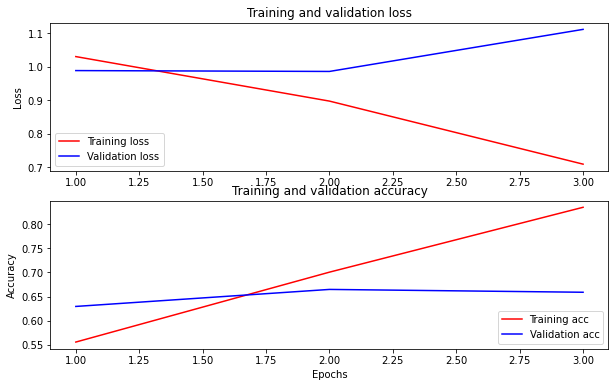

In [ ]:
# plot change
plot_loss(history)

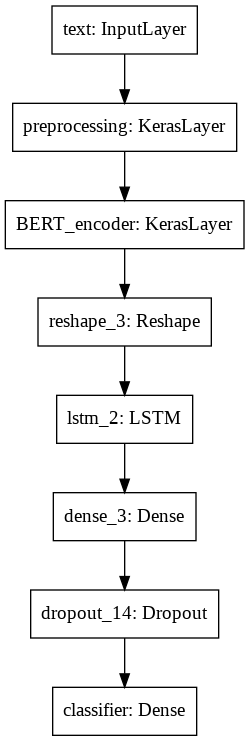

In [ ]:
# model structure
tf.keras.utils.plot_model(classifier_model)

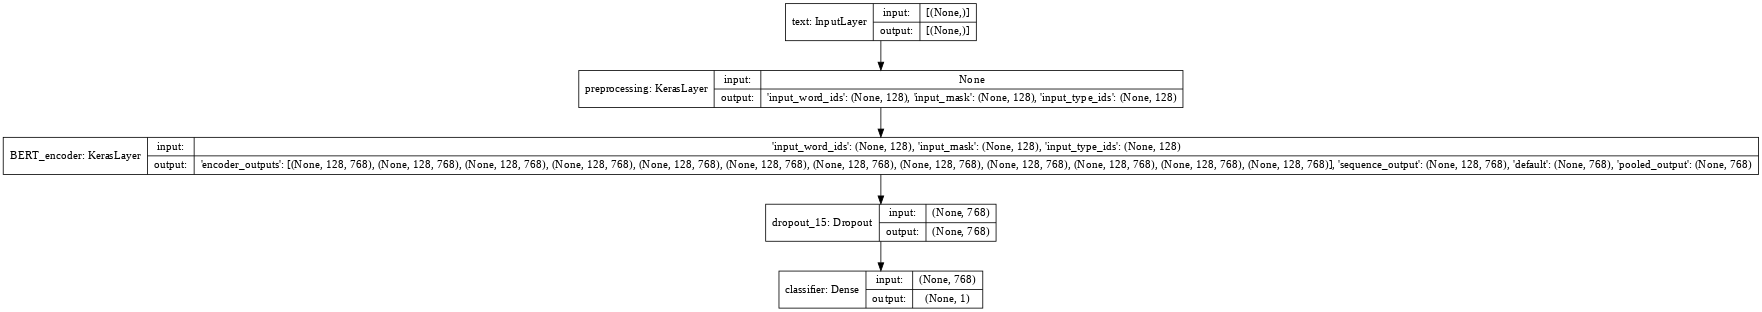

In [ ]:
#shapes of inputs
tf.keras.utils.plot_model(classifier_model, show_shapes=True, dpi=58)

In [ ]:
def create_test_results():
  fold = 0
  train, test = stratified_10_fold_split(df, fold = fold, val = False, batch_size = batch_size) 
  classifier_model.evaluate(test)
  preds = classifier_model.predict(test)
  pred_prob = [i[0] for i in preds]
  pred_label = [1 if i > 0.5 else 0 for i in pred_prob]
  sentence = []
  actual_label = []
  for text_batch, label_batch in test: 
    for i in range(len(text_batch)): 
      sentence.append(text_batch.numpy()[i])
      actual_label.append(label_batch.numpy()[i])
  test_results = pd.DataFrame(zip(sentence, actual_label, pred_label, pred_prob), 
                              columns = ['sentence', 'actual', 'pred', 'pred_prob'])
  test_results['diff'] = [np.abs(a-b) for a,b in zip(test_results['actual'], test_results['pred_prob'])]
  print(len(test_results[test_results.actual == test_results.pred]) / len(test_results))
  return test_results

In [ ]:
test_results = create_test_results()

Train  3062
Test  340
11/11 [==============================] - 3s 304ms/step - loss: 0.9013 - binary_accuracy: 0.5882
0.5970588235294118


Probability Distribution


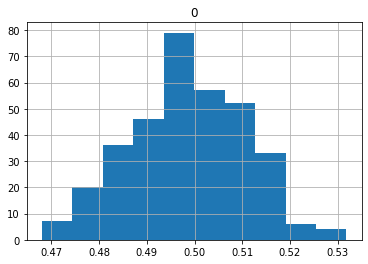

Actual vs. Predicted Labels


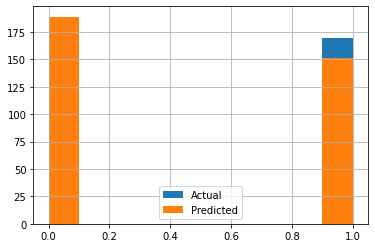

In [ ]:
print('Probability Distribution')
pd.DataFrame([i[0] for i in test_results['pred_prob']]).hist()
plt.show()
print('Actual vs. Predicted Labels')
test_results['actual'].hist()
test_results['pred'].hist()
plt.legend(['Actual', 'Predicted'])


Probability Distribution


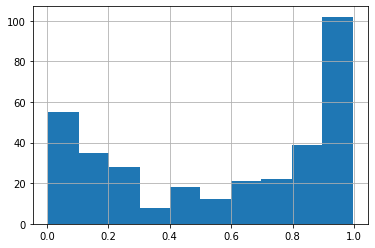

Actual vs. Predicted Labels


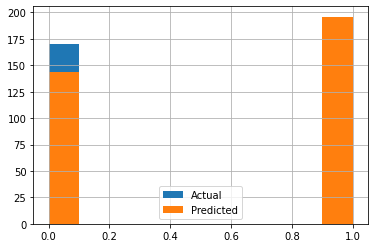

In [ ]:
print('Probability Distribution')
test_results['pred_prob'].hist()
plt.show()
print('Actual vs. Predicted Labels')
test_results['actual'].hist()
test_results['pred'].hist()
plt.legend(['Actual', 'Predicted'])


In [ ]:
test_results.sort_values('diff', ascending = False).head(20)

,sentence,actual,pred,pred_prob,diff
258,"b'Third , a range of public policies helped fa...",0,1,0.992748,0.992748
24,b'He will create flexible education accounts t...,0,1,0.992496,0.992496
29,"b""Calling fatherlessness a `` social evil '' a...",0,1,0.990194,0.990194
205,b'The wealthy do often use their wealth for po...,0,1,0.986282,0.986282
83,b'As our worst economic crisis since the Depre...,0,1,0.983511,0.983511
77,"b'For the new fundamentalists , the old balanc...",1,0,0.021978,0.978022
251,b'Progressives also could have been demanding ...,0,1,0.975942,0.975942
14,"b'And , not surprisingly given the extent to w...",0,1,0.975428,0.975428
269,"b""One recent editorial concluded that `` the o...",0,1,0.973576,0.973576
13,b'Since politics is about shaping government p...,1,0,0.027174,0.972826


In [ ]:
[sentence for sentence in test_results.sort_values('diff', ascending = False).head(20)['sentence']]

[b'Third , a range of public policies helped facilitate this economic mobility and opportunity : a strong minimum wage , grants for low-income students to go to college , generously subsidized state college tuition , a reliable unemployment insurance system , enforcement of the right to join a union , major incentives for homeownership , and a solid safety net for those falling on hard times .',
 b'He will create flexible education accounts that workers can use to retrain , provide retraining assistance for workers in sectors of the economy vulnerable to dislocation before they lose their jobs , and provide additional assistance for workers to afford health care .',
 b"Calling fatherlessness a `` social evil '' and the `` engine driving our worst social problems , '' they promote father presence as a panacea for poverty , failure in school , emotional and behavioral problems among boys , premarital sex and pregnancy among girls , suicide , child abuse , and even social inequality .",
 

In [ ]:
# save model
model_path = 'baseline_electra_ibc'
saved_model_path = './baseline_electra_ibc_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path)

model.save('path/to/location')


In [ ]:
# reload saved model
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
# test on new input
